# Рекомендация тарифов

## Содержание
1. Введение  
    1.1. Описание проекта  
    1.2.  Описание данных  
2. Библиотеки и функции
3. Данные  
    3.1. Разбиение данных на выборки  
4. Выбор лучшей модели  
    4.1. Логистическая регрессия  
    4.2. Дерево решений  
    4.3. Случайный лес  
    4.3.1. Случайный лес с дефолтной глубиной max_depth=10 и разным количеством деревьев  
    4.3.2. Случайный лес с разной глубиной и разным количеством деревьев  
    4.4. Выбор лучшей модели  
5. Проверка модели на тестовой выборке  
6. Проверка модели на адекватность  
7. Выводы  

## Введение
### Описание проекта
Оператор мобильной связи «Мегалайн» хочет построить систему, способную проанализировать поведение клиентов, пользующихся архивными тарифами, и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Задача:** построить модель классификации, которая выберет подходящий тариф, на основании данных о поведении клиентов, которые уже перешли на эти тарифы. **Метрика: *accuracy*.**

### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- *сalls* — количество звонков,
- *minutes* — суммарная длительность звонков в минутах,
- *messages* — количество sms-сообщений,
- *mb_used* — израсходованный интернет-трафик в Мб,
- *is_ultra* — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Библиотеки и функции

In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [2]:
def regplot(x, y, data, xlabel, ylabel, ax, scatter_color, line_color):
    sns.regplot(x, y, data, scatter_kws={'color': scatter_color, 'alpha':0.3}, line_kws={'color': line_color}, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('Корреляция r = {}'.format(round(corr.at[x, y], 2)));

In [3]:
def train_valid_test_split(data, target_col):
    features = data.drop(target_col, axis=1)
    target = data[target_col]

    features_valid_train, features_test, target_valid_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=123)

    features_train, features_valid, target_train, target_valid = train_test_split(
    features_valid_train, target_valid_train, test_size=0.25, random_state=123)
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

##   Данные

In [4]:
data = pd.read_csv('/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


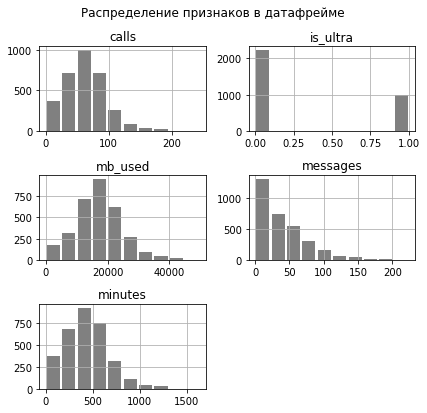

In [6]:
data.hist(figsize=(6,6), color='grey', rwidth=0.85)
plt.suptitle('Распределение признаков в датафрейме');
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [7]:
print('Распределение категорий в целевом признаке:')
print(data['is_ultra'].value_counts(normalize=True)*100)
print('\n0 = Smart', '\n1 = Ultra')

Распределение категорий в целевом признаке:
0    69.352831
1    30.647169
Name: is_ultra, dtype: float64

0 = Smart 
1 = Ultra


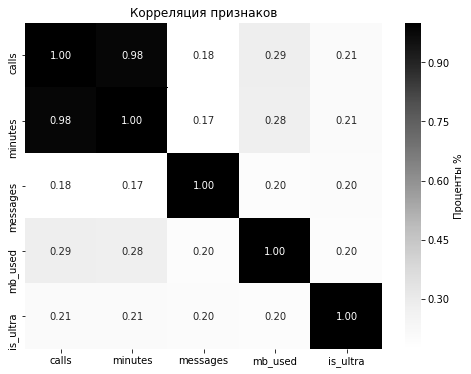

In [8]:
f, ax = plt.subplots(figsize=[8,6])
sns.heatmap(data.corr(), annot=True, fmt=".2f",cbar_kws={'label': 'Проценты %'},cmap="Greys",ax=ax)
ax.set_title('Корреляция признаков');

In [9]:
cols_to_draw = ['calls', 'minutes', 'messages', 'mb_used']
col_names = ['звонки', 'минуты', 'сообщения', 'интернет']
corr = data[cols_to_draw].corr()

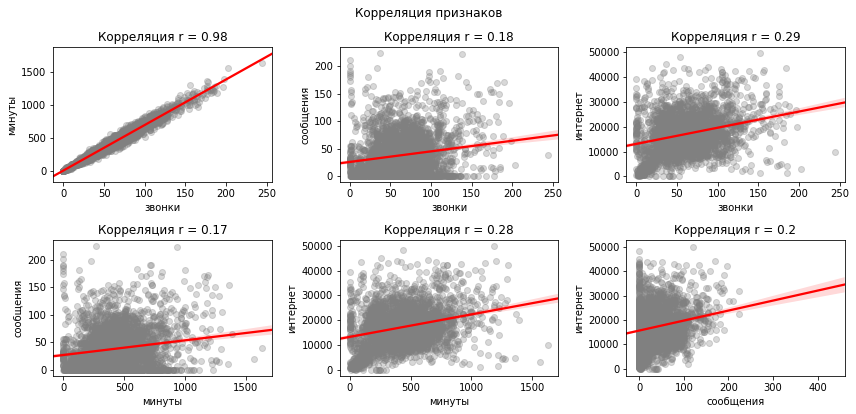

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

for ax, x_y_pair, label_pair in zip([ax1, ax2, ax3, ax4, ax5, ax6],
                                    itertools.combinations(cols_to_draw, 2),
                                    itertools.combinations(col_names, 2)):
    regplot(x_y_pair[0], x_y_pair[1], data,label_pair[0], label_pair[1], ax, scatter_color='grey', line_color='red')

fig.suptitle('Корреляция признаков');
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Удаляем один из мультиколинеарных признаков:

In [11]:
data = data.drop(['calls'], axis=1)

**Выводы**  

Имеем выборку, состоящую из 3214 объектов. В таблице всего 5 признаков, 1 из который - целевой (`is_ultra`). Категории в целевом признаке распределены неравномерно: почти 70 % объектов относятся к категории *Smart*, только 30 % - к категории *Ultra*.

Выявлено 2 коррелирующих признака: это количество звонков и минуты разговоров. Решено было избавиться от количества звонков. 

### Разбиение данных на выборки

In [12]:
target_col = 'is_ultra'

In [13]:
(features_train, features_valid, features_test, 
 target_train, target_valid, target_test) = train_valid_test_split(data, target_col)

for name, sample in zip(['features_train', 'features_valid', 'features_test',
                         'target_train', 'target_valid', 'target_test'],
                        [features_train, features_valid, features_test,
                         target_train, target_valid, target_test]):
    print(name,':', sample.shape)

features_train : (1928, 3)
features_valid : (643, 3)
features_test : (643, 3)
target_train : (1928,)
target_valid : (643,)
target_test : (643,)


## Выбор лучшей модели

Нам нужно решить задачу бинарной классификации, так как пользователи выбирают один из дву предложенных тарифов. Для решения этой задачи обратимся к следующим моделям из библиотеки *sklearn*:
- Логистическая регрессия *LogisticRegression*
- Дерево решений *DecisionTreeClassifier*
- Случайный лес *RandomForestClassifier*

Проверим *Accuracy* на каждой из них, протестируем разные гиперпараметры.

In [14]:
models_dict = {}

### Логистическая регрессия

Попробуем обучить регрессию с разными параметрами penalty и solver.

In [15]:
penalties = ['l1', 
             'l2',  
             'none']
solvers = [['liblinear', 'saga'], 
           ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  
           ['newton-cg', 'lbfgs', 'sag', 'saga']]

In [16]:
best_result = 0
best_model = None
for penalty, solver in zip(penalties, solvers):
    for s in solver:
        clf = LogisticRegression(penalty=penalty, random_state=123, solver=s).fit(features_train, target_train)
        clf_result = clf.score(features_valid, target_valid)
        #print('Качество логистической регрессии c {} / {} на валидационной выборке:'.format(penalty, s), round(clf_result, 3))
        if clf_result > best_result:
            best_result = clf_result
            best_model = clf

In [17]:
models_dict['LR'] = best_result
print('Лучшая модель логистической регрессии:', best_model)
print('Результат:', round(best_result, 3))

Лучшая модель логистической регрессии: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Результат: 0.736


**Вывод:** Лучший результат показывает модель, которая штрафует за переобучение с помощью Lasso, то есть с помощью суммы модулей весов, а не с помощью дефолтных квадратов (Lasso борется с мультиколинеарностью).

### Дерево решений
Проведем классификацию деревом решений с разной глубиной дерева

In [18]:
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0
tree_result_list = []

for depth in range(1, 21):
    tree_model = DecisionTreeClassifier(random_state=123, max_depth=depth)
    tree_model.fit(features_train, target_train)
    
    tree_result = tree_model.score(features_valid, target_valid)
    tree_result_list.append(tree_result)

    if tree_result > best_tree_result:
        best_tree_model = tree_model
        best_tree_result = tree_result
        best_tree_depth = depth
        
print('Accuracy лучшей модели в дереве решений:', round(best_tree_result, 3))
print('Достигается при глубине', best_tree_depth)

models_dict['DT'] = best_tree_result

Accuracy лучшей модели в дереве решений: 0.784
Достигается при глубине 3


Посмотрим, как глубина дерева влияет на результат.

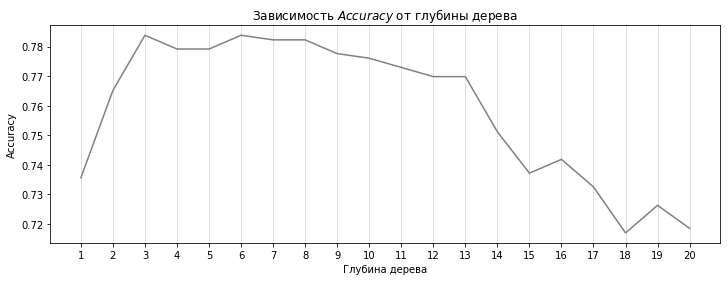

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(tree_result_list)+1), tree_result_list, color='grey')
plt.xlabel('Глубина дерева');
plt.ylabel('Accuracy');
plt.title('Зависимость $Ассuracy$ от глубины дерева');
plt.grid(axis='x', alpha=0.5);
plt.xticks(np.arange(1, len(tree_result_list)+1, step=1));

**Вывод:** решающее дерево показывает лучший результат, чем логистическая регрессия. График позволяет увидеть, как быстро наступает переобучение при увеличении гиперпараметра глубины: самый точный результат классификаци *0.78* достигнут при глубине дерева = 3.

### Случайный лес
#### Случайный лес с дефолтной глубиной `max_depth=10` и разным количеством деревьев

In [20]:
best_f_model = None
best_f_result = 0
best_f_est = 0
f_list = []

for est in range(1, 100):
    f_model = RandomForestClassifier(random_state=123, n_estimators=est)
    f_model.fit(features_train, target_train)
    f_result = f_model.score(features_valid, target_valid)
    f_list.append(f_result)
    if f_result > best_f_result:
        best_f_model = f_model
        best_f_result = f_result

print("Accuracy наилучшей модели случайного леса на валидационной выборке:", round(best_f_result, 3))

Accuracy наилучшей модели случайного леса на валидационной выборке: 0.799


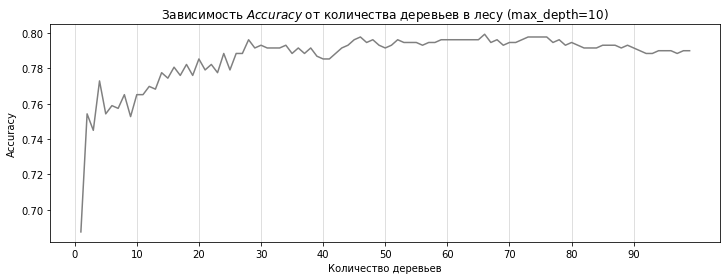

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(f_list)+1), f_list, color='grey')
plt.xlabel('Количество деревьев')
plt.ylabel('Accuracy');
plt.title('Зависимость $Ассuracy$ от количества деревьев в лесу (max_depth=10)');
plt.grid(axis='x', alpha=0.5);
plt.xticks(np.arange(0, len(f_list)+1, step=10));

**Вывод:** Accuracy модели Случайный лес резко растет с увеличением количества деревьев до 5, потом плавно увеличивается примерно до 30, дальше существенного улучшения не наступает. Значит, нет необходимости строить лес большого размера. Чтобы зря не тратить память при вычислении результата, ограничим следующую модель 60 деревьями.

#### Случайный лес с разной глубиной и разным количеством деревьев

In [22]:
MAX_DEPTH = 21
MAX_EST = 61

In [23]:
best_forest_model = None
best_forest_result = 0
best_forest_est = 0
best_forest_depth = 0
est_dict = {}
for est in range(10, MAX_EST, 10):
    forest_result_list = []
    for depth in range (1, MAX_DEPTH):
        forest_model = RandomForestClassifier(random_state=123, n_estimators=est, max_depth=depth)
        forest_model.fit(features_train, target_train) 
        forest_result = forest_model.score(features_valid, target_valid)
        forest_result_list.append(forest_result)
        if forest_result > best_forest_result:
            best_forest_model = forest_model
            best_forest_result = forest_result
            best_forest_est = est
            best_forest_depth = depth
    est_dict[est] = (forest_result_list)
print("Accuracy наилучшей модели случайного леса на валидационной выборке:", round(best_forest_result, 3))
print("Количество деревьев:", best_forest_est)
print("Максимальная глубина:", best_forest_depth)

models_dict['RF'] = best_forest_result

Accuracy наилучшей модели случайного леса на валидационной выборке: 0.806
Количество деревьев: 40
Максимальная глубина: 13


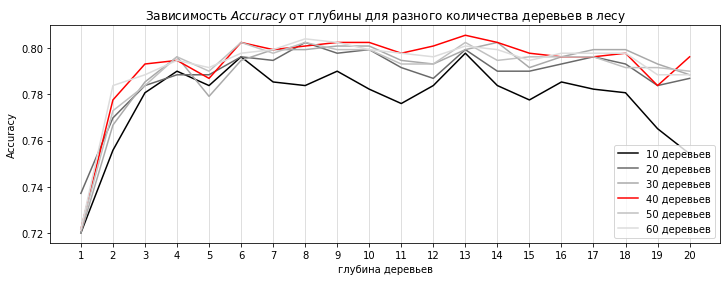

In [24]:
colors = ['black','dimgray', 'darkgrey',
          'red','silver','gainsboro']
plt.figure(figsize=(12, 4))
for i, color in zip(range(10, MAX_EST, 10), colors):
    plt.plot(range(1, MAX_DEPTH), est_dict[i], label=str(i), color=color)
    plt.legend(['10 деревьев', '20 деревьев','30 деревьев', 
                '40 деревьев','50 деревьев', '60 деревьев'], loc='lower right')
plt.xlabel('глубина деревьев')
plt.ylabel('Accuracy');
plt.grid(axis='x', alpha=0.5);
plt.xticks(np.arange(1, MAX_DEPTH, step=1));
plt.title('Зависимость $Ассuracy$ от глубины для разного количества деревьев в лесу');

**Вывод:** Модель случайного леса показала лучший результат при следующих гиперпараметрах: 40 деревьев глубиной 13. На графике вмдно, что именно это количество деревьев дает постоянный пророст *Accuracy*.

### Выбор лучшей модели

In [25]:
models_df = pd.DataFrame(data=models_dict, index=['Accuracy'])

In [26]:
models_df.round(2)

,LR,DT,RF
Accuracy,0.74,0.78,0.81


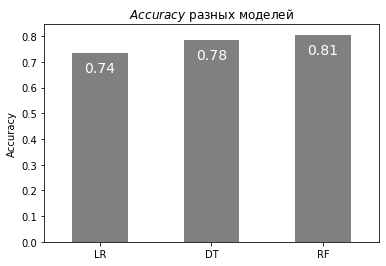

In [27]:
ax = models_df.T.plot(kind='bar', label='index', color='grey', rot=0, figsize=(6,4), legend=False)

ax.text(x=0, y=models_df.iloc[0][0]-0.075, s=str(models_df.iloc[0][0].round(2)), color = 'white', ha="center", size=14)
ax.text(x=1, y=models_df.iloc[0][1]-0.075, s=str(models_df.iloc[0][1].round(2)), color = 'white', ha="center", size=14)
ax.text(x=2, y=models_df.iloc[0][2]-0.075, s=str(models_df.iloc[0][2].round(2)), color = 'white', ha="center", size=14)
plt.ylabel('Accuracy');
plt.title('$Ассuracy$ разных моделей');

**Вывод**: в качестве модели выбираем Случайный лес из 40 деревьев с глубиной 13 c Accuracy *0.81* на валидационной выборке.

## Проверка модели на тестовой выборке

In [28]:
features_concatenated = pd.concat([features_train, features_valid])
target_concatenated = pd.concat([target_train, target_valid])

In [29]:
my_model = RandomForestClassifier(random_state=123, n_estimators=40, max_depth=13)
my_model.fit(features_concatenated, target_concatenated) 
my_result = my_model.score(features_test, target_test)
print(f'Результат модели на тестовой выборке: {my_result:.3f}')

Результат модели на тестовой выборке: 0.804


## Проверка модели на адекватность

In [30]:
sanity_1_0 = np.random.randint(2, size=target_test.shape[0])
sanity_0 = np.random.randint(1, size=target_test.shape[0])

In [31]:
sanity_1_0_accuracy = accuracy_score(target_test, sanity_1_0)
sanity_1_0_accuracy

0.48989113530326595

In [32]:
sanity_0_accuracy = accuracy_score(target_test, sanity_0)
sanity_0_accuracy

0.6998444790046656

**Вывод:** accuracy на предсказаниях нашей модели лучше, чем на случайном наборе ответов. При этом результат векторе из нолей лучше, так как изначально у нас классы 1 и 0 были несбалансированы.

## Выводы

Перед нами стояла задача построить систему, способную предложить пользователям подходящий тариф: СМАРТ или УЛЬТРА. Это задача классификации.

Мы проверили несколько моделей: логистическую регрессию, дерево решений и случайный лес. Наибольшее внимание уделили лесу, перебрали несколько гиперпараметров: несколько вариантов количества деревьев, каждое из которых разной глубины.

Модели показали следующие результаты:

модель | качество на валидации
-------|----------------------
логистическая регрессия|0.73
дерево решений|0.78
случайный лес|0.81

**В итоге** случайный лес победил, с пареметрами 40 деревьев глубиной 13. Эта модель показала *Accuracy* 0.81 на тестовой выборке.

Проверка модели на адекватность показала, что предложения тарифов, полученные с помощью модели, лучше, чем случайный выбор одного из двух или чем просто рекомендация тарифа СМАРТ всем абонентам подряд.